In [1]:
import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [3]:
time_window = 50
time_step = 25
trial_bin_size = 20
n_splits = 300
group_dict = OrderedDict([('1 (hashtag)',[12]),('1 (letter)',[13]),('1 (flip)',[14]),('Set size 2',[20])])
train_labels = ['1 (hashtag)','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [5]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    flip_idx = ydata==2
    xdata_flip, ydata_flip = xdata[flip_idx], ydata[flip_idx]
    xdata_flip, ydata_flip = wrangl.bin_trials(xdata_flip,ydata_flip)
    xdata, ydata = xdata[~flip_idx], ydata[~flip_idx]

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)

        flip_idx_test =  np.random.choice(range(len(ydata_flip)),int(len(ydata_flip)*.75),replace=False)
        X_test_flip, y_test_flip = xdata_flip[flip_idx_test], ydata_flip[flip_idx_test]
        X_test_all = np.concatenate([X_test_all,X_test_flip])
        y_test = np.concatenate([y_test,y_test_flip])

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
        wrangl.ifold+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [6]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1hvs2_with_1l_1f')
interp.save_results()

In [10]:
interp.load_results()
interp.labels = np.array(['1 (hashtag)','1 (letter)','1 (flip)','2'])

No filename provided. Loading most recent results.


In [12]:
idx_12 = np.isin(interp.labels,['1 (hashtag)','1 (letter)','2'])
interp.labels = interp.labels[idx_12]
interp.confidence_scores = interp.confidence_scores[:,:,:,idx_12]

1
Significant timepoints: [112 136 160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520
 544 568 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
Saving output\figures\1hvs2_with_1l_1fhyperplane_1hl12_conf.pdf
Saving output\figures\1hvs2_with_1l_1fhyperplane_1hl12_conf.png


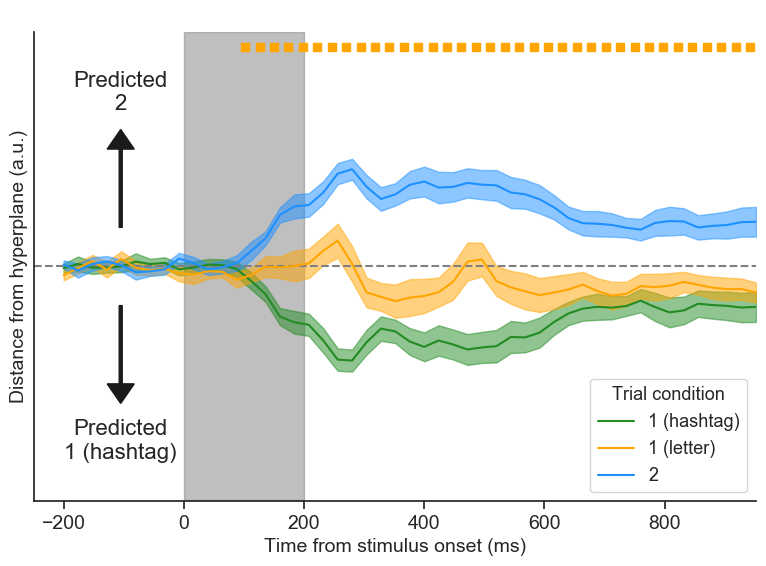

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
interp.colors = ['forestgreen','orange','dodgerblue','firebrick']
interp.plot_hyperplane(
    significance_testing_pair=[(1,2)],sig_y=2.8, stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=True,subtitle='_1hl12_conf')

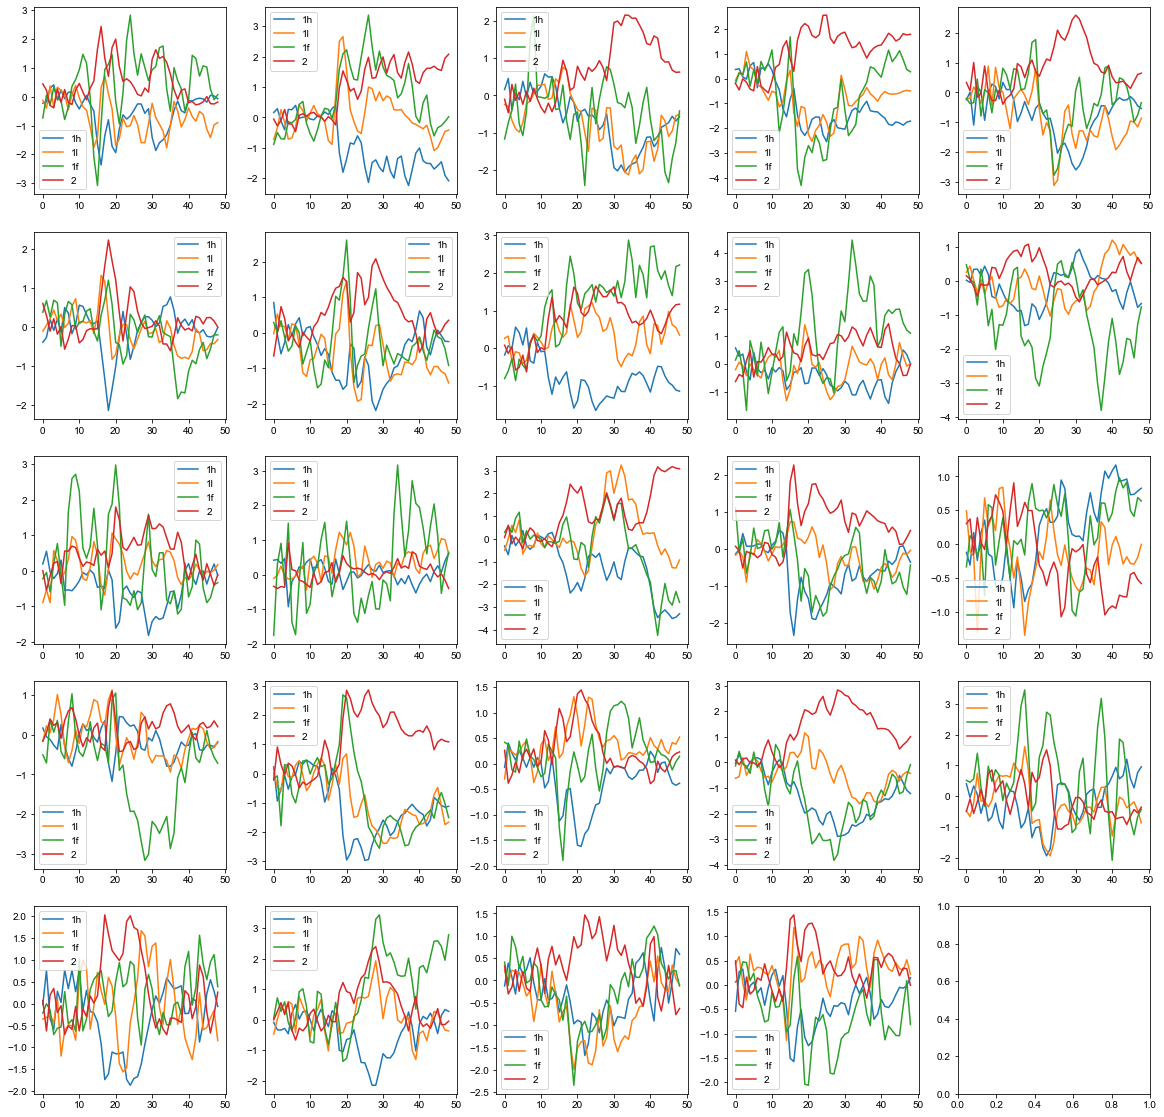

In [131]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(5,5,figsize=(20,20))
for i in range(exp.nsub):
    ax = axes.flat[i]
    v = np.mean(interp.confidence_scores,2)[i]
    ax.plot(v)
    ax.legend(labels=['1h','1l','1f','2'])

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
means = np.mean(np.mean(interp.confidence_scores,2)[:,(interp.t<1900)&(interp.t>500)],1)


In [88]:
df = pd.DataFrame(means)

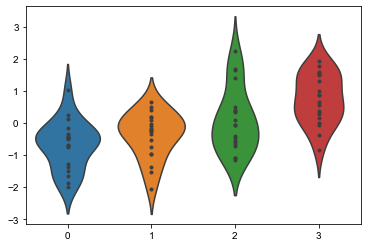

In [89]:
sns.violinplot(data=df,inner='points')

In [90]:
import scipy.stats as sista

In [91]:
sista.ttest_rel(df[1],df[2])

Ttest_relResult(statistic=-2.4356156589806512, pvalue=0.024886596638635943)